# Introduction to Code Contributions
The three contributions presented in the last chapter are implemented in different modules. To distinguish between features at a fixed time step and aggregated features, the aggregated features are referred to with ```X```, features of one time step with ```X_t``` and features of an particular individual with ```X_i```.

In [1]:
import sys
import numpy as np
sys.path.append("../")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from aif360.algorithms.inprocessing import PrejudiceRemover

from long_term_fairness.ltf_plot import LongTermFairnessPlot
from long_term_fairness.ltf_data.group_data_generator import GroupDataGenerator as DataGenerator
from long_term_fairness.ltf_aif.longterm_aif import AifLongTermMetric, AifLongTermPrediction

Import error: No module named 'tensorflow'


# 1. Data Generator
The data generator implements the dynamic data generation. The details about the data generation are explained in the previous section.

In [2]:
# Initialization of the generator. The provided values are the default values.
generator = DataGenerator(mean_pos=[10, 7],             # The mean for the positive cluster.
                          cov_pos=[[1.2, 0], [0, 1.3]], # Covariance for the positive cluster.
                          mean_neg=[0, 1],              # The mean for the negative cluster.
                          cov_neg=[[1, 0], [0, 1.2]],   # Covariance for the negative cluster.
                          degree=3,                     # Number of previous steps t considered in dynamics.
                          discrimination_factor=.7,     # Fraction of labels in first step.
                          num_positive_label=500,       # Number of positive instances.
                          num_negative_label=500,       # Number of negative instances.
                          neg_label=0, # The label considered negative.
                          pos_label=1, # The label considered positive.
                          neg_class=0, # The protected attribute class considered negative.
                          pos_class=1) # The protected attribute class considered positive.

In [3]:
# The generator takes three arguments, the features X, true labels _y, and predictions y_hat.
# generator.sample(X,      # 3D, all previous features of shape [t, n, m]
#                  y,      # 2D, all previous true labels of shape [t, n]
#                  y_hat   # 2D, all previous predictions of shape [t, n]


In [6]:
# When called with None, None, None the generator samples the initial data as 
# explained in the previous section.
X, x_sens, y = generator.sample(None, None, None)
print(X.shape)
print(x_sens.shape)
print(y.shape)

(1000, 2)
(1000,)
(1000,)


In [10]:
# Otherwise, new data is sampled either group or individual wise.
# Examples ae provided in the following notebooks.
X_new, x_sens_new, y_new = generator.sample([X], [x_sens], [y])
print(X_new.shape)
print(x_sens_new.shape)
print(y_new.shape)

(1000, 2)
(1000,)
(1000,)


In [12]:
# This function returns the true label given data.
# For instance, this is necessary for the data generating boundary plot.
labels = generator.get_label(X_new, x_sens_new)
print(labels.shape)

(1000,)


# 2. AIF360 Wrappers
Two wrapper classes provide access to aif360 metrics and functions to be used in the long term framework.

## 2.1. AIF360 Long Term Prediction
Interface to use AIF360s algorithms for the long term plot

In [18]:
# LTF classifier from AIF360 classifier.
# https://aif360.readthedocs.io/en/latest/modules/inprocessing.html
clf = AifLongTermPrediction(clf=PrejudiceRemover(), # Any AIF360
                            pos_class=1, 
                            neg_class=0, 
                            pos_label=1, 
                            neg_label=0)

In [19]:
# Fits clf to the data. In the background, X_t, X_sens_t and y_t are stacked into an aif360 data frame
# and the fit method is called.
clf.fit(X_new, 
        x_sens_new, 
        y_new)

In [21]:
# Predict data of one time step. In the background, X_t and X_sens_t are stacked into an aif360 data frame
# and the predict method is called.
y_hat = clf.predict(X_new, 
                    x_sens_new)

print(y_hat.shape)

(1000,)


## 2.1. AIF360 Long Term Metric
The class provides an interface to use AIF360 metrics for long term prediction.

In [22]:
# The default metrics are accuracy and disparate impact. It is possible to provide more than two metrics
# but the plot is unclear then. Any classification metric from aif 360 can be passed as string.
# https://aif360.readthedocs.io/en/latest/modules/metrics.html#classification-metric
metric = AifLongTermMetric(metrics=["accuracy", "disparate_impact"],
                           pos_class=1, 
                           neg_class=0, 
                           pos_label=1, 
                           neg_label=0)

In [24]:
# Computes the metrics on a snapshot of the data.
metric.metric(X_new, 
              x_sens_new, 
              y_new, 
              y_hat)

[1.0, 0.4285714285714286]

# 3. Long Term Plot
Runs decision process over several generations.

In [28]:
l = LongTermFairnessPlot(generator,     # Must implement .sample() function as described above.
                         clf,           # Must implement fit(X, X_sens, y) and predict(X, X_sense).
                         metric.metric, # Must implement .metric(X_t, x_sense_t, y_t, y_hat_t)
                         x_lim=[-3, 12], # Axes limits for the final plot.
                         y_lim=[-1, 13]) # Axes limit for the final plot.

In [31]:
# Initialize the data
l.init_data()

In [32]:
# Runs one iteration with the true data.
l.run_generation()

[1.0, 0.4285714285714286]

In [33]:
# Run baseline generation (assuming all previous predictions to be positive)
l.run_baseline_generation()

[0.999, 0.4273504273504274]

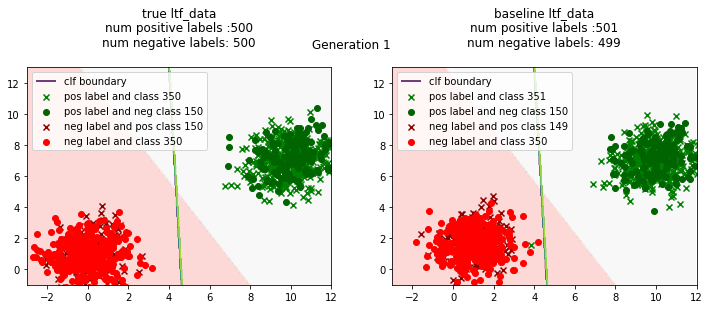

In [34]:
# Plot the data points of the generation.
l.plot_generation()

In [38]:
# Combines the previous steps; Initialize data, run both generations
l.run(10)

/home/danilo/anaconda3/lib/python3.7/site-packages/aif360/metrics/classification_metric.py:264: RuntimeWarning: invalid value encountered in double_scalars
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/home/danilo/anaconda3/lib/python3.7/site-packages/aif360/metrics/classification_metric.py:265: RuntimeWarning: invalid value encountered in double_scalars
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/home/danilo/anaconda3/lib/python3.7/site-packages/aif360/metrics/classification_metric.py:264: RuntimeWarning: invalid value encountered in double_scalars
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/home/danilo/anaconda3/lib/python3.7/site-packages/aif360/metrics/classification_metric.py:265: RuntimeWarning: invalid value encountered in double_scalars
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/home/danilo/anaconda3/lib/python3.7/site-packages/aif360/metrics/classification_metric.py:264: RuntimeWarning: invalid value encountered in double_scalars
  TP

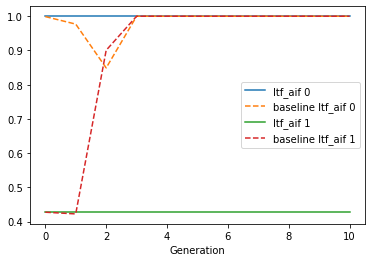

In [39]:
# Plot the metrics over all steps.
l.plot_ltf()